In [244]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize

In [ ]:
''' RED PAPER 02/05/23  '''

In [245]:
''' 1 '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu):
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df


In [246]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0)

In [247]:
''' OLS GLS estimation 1 repetiotion'''
def ols_gls_estimation(df):
    # convert data to float64 data type
    df = df.astype('float64')
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(theta_hat[0, 0])) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    print("theta_gls = {:.4f}".format(theta_gls[0, 0]))

In [248]:
ols_gls_estimation(df)

OLS parameter estimates:
alpha_hat = 0.1563
beta_hat = 0.7301
gamma_hat = 0.2577
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2344
beta_gls = 0.5844
gamma_gls = 0.2803
theta_gls = 1.0000


In [ ]:
''' 1 rep --> gls way better
OLS parameter estimates:
alpha_hat = 0.0987
beta_hat = 0.7426
gamma_hat = 0.3107
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2053
beta_gls = 0.5110
gamma_gls = 0.3058
theta_gls = 1.0000
'''

In [ ]:
''' 0.2, 0.5, 0.3, 0.9 '''
OLS parameter estimates:
alpha_hat = 0.1232
beta_hat = 0.7472
gamma_hat = 0.2308
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2039
beta_gls = 0.6025
gamma_gls = 0.2767
theta_gls = 1.0000

Laplace parameter estimates OLS 0.1:
alpha_l = 0.1232
beta_l = 0.7472
gamma_l = 0.2308

Laplace parameter estimates GLS 0.1:
alpha_l = 0.2039
beta_l = 0.6025
gamma_l = 0.2767

Laplace parameter estimates GLS 0.9:
alpha_l = 0.2039
beta_l = 0.6025
gamma_l = 0.2767

#10 rep == #100 rep == #1000 rep 6m38s
OLS parameter estimates:
alpha_hat = 0.1395
beta_hat = 0.7202
gamma_hat = 0.2877
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2652
beta_gls = 0.4740
gamma_gls = 0.3271
theta_gls = 1.0000

In [153]:
''' Iterations M'''
def ols_gls_estimation2(df, M):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values     # extract data
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    beta_ols = np.empty((M, 3)) # initialize arrays to store results
    beta_gls = np.empty((M, 3))
    theta_ols = np.empty(M)
    theta_gls = np.empty(M)
    y_sim = []
    M = len(y_sim)

    for i in range(M):
        sigma2 = 1
        #epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=T)
        epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=(T)) # generate new epsilon values for each iteration
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        epsilon = epsilon.reshape((-1, 1))
        epsilon_lag = epsilon_lag.reshape((-1, 1))
        y_lag = np.roll(y, 1)
        y_lag[0] = 0   

        X = np.column_stack((np.ones_like(x), y_lag, x)) # OLS estimation of the parameters
        beta_ols[i] = np.linalg.inv(X.T @ X) @ X.T @ y
        y_sim[i] = X @ beta_ols[i] + epsilon[i] # generate new y values for each iteration
        
        ε = y_sim[i] - X @ beta_ols[i]
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_ols[i] = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls[i] = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y_sim[i]
        theta_gls[i] = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
    
    print("OLS parameter estimates:") # print results
    print("alpha_hat = {:.4f}".format(np.mean(beta_ols[:, 0])))
    print("beta_hat = {:.4f}".format(np.mean(beta_ols[:, 1])))
    print("gamma_hat = {:.4f}".format(np.mean(beta_ols[:, 2])))
    print("theta_hat = {:.4f}".format(np.mean(theta_ols))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean(beta_gls[:, 0])))
    print("beta_gls = {:.4f}".format(np.mean(beta_gls[:, 1])))
    print("gamma_gls = {:.4f}".format(np.mean(beta_gls[:, 2])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls))) 


In [176]:
M = 10
ols_gls_estimation2(df, M)

OLS parameter estimates:
alpha_hat = 0.0000
beta_hat = 0.0000
gamma_hat = 0.0000
theta_hat = 0.0000
GLS parameter estimates:
alpha_gls = 0.0133
beta_gls = 0.0717
gamma_gls = 0.0335
theta_gls = 0.0000


In [180]:
M = 10000
ols_gls_estimation2(df, M)

OLS parameter estimates:
alpha_hat = 0.0000
beta_hat = 0.0000
gamma_hat = 0.0000
theta_hat = 0.3425
GLS parameter estimates:
alpha_gls = 0.0000
beta_gls = 0.0000
gamma_gls = 0.0000
theta_gls = -0.0784


In [181]:
def ols_gls_estimation3(df, M):
    beta_hat_list = []
    beta_gls_list = []
    theta_hat_list = []
    theta_gls_list = []
    
    for i in range(M):
        df = df.astype('float64') # convert data to float64 data type
        x = df['x'].values # extract data
        y = df['y'].values
        epsilon_y = df['epsilon_y'].values
        T = len(y)

        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x)) # OLS estimation of the parameters
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

        beta_hat_list.append(beta_hat)
        beta_gls_list.append(beta_gls)
        theta_hat_list.append(theta_hat[0, 0])
        theta_gls_list.append(theta_gls[0, 0])
    
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(np.mean([b[0] for b in beta_hat_list])))
    print("beta_hat = {:.4f}".format(np.mean([b[1] for b in beta_hat_list])))
    print("gamma_hat = {:.4f}".format(np.mean([b[2] for b in beta_hat_list])))
    print("theta_hat = {:.4f}".format(np.mean(theta_hat_list))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean([b[0] for b in beta_gls_list])))
    print("beta_gls = {:.4f}".format(np.mean([b[1] for b in beta_gls_list])))
    print("gamma_gls = {:.4f}".format(np.mean([b[2] for b in beta_gls_list])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls_list))) 


In [182]:
M = 10
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [183]:
M = 100
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [79]:
M = 100
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [168]:
''' Iterations M'''
def ols_gls_estimation4(df, M):
    for i in range(M):
        # convert data to float64 data type
        df = df.astype('float64')
        # extract data
        x = df['x'].values
        y = df['y'].values
        epsilon_y = df['epsilon_y'].values
        T = len(y)
        
        # initialize arrays to store results
        beta_ols = np.empty((M, 3))
        beta_gls = np.empty((M, 3))
        theta_ols = np.empty(M)
        theta_gls = np.empty(M)
        y_sim = np.empty((M, T))
        # generate new epsilon values for each iteration
        sigma2 = 1
        epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=T)
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        #epsilon = epsilon.reshape((-1, 1))
        #epsilon_lag = epsilon_lag.reshape((-1, 1))
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        #y_lag = y_lag.reshape((-1, 1))
        # OLS estimation of the parameters
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_ols_curr = np.linalg.inv(X.T @ X) @ X.T @ y
        beta_ols[i] = beta_ols_curr
        # generate new y values for each iteration
        epsilon = epsilon.reshape((-1, 1))
        y_sim[i] = beta_ols_curr[0] + beta_ols_curr[1] * y_lag + beta_ols_curr[2] * x + epsilon

#np.tile(epsilon, (1, 3))
        ε = y_sim[i] - X @ beta_ols_curr
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_ols[i] = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls_curr = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y_sim[i]
        beta_gls[i] = beta_gls_curr
        theta_gls[i] = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    # print results
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(np.mean(beta_ols[:, 0])))
    print("beta_hat = {:.4f}".format(np.mean(beta_ols[:, 1])))
    print("gamma_hat = {:.4f}".format(np.mean(beta_ols[:, 2])))
    print("theta_hat = {:.4f}".format(np.mean(theta_ols))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean(beta_gls[:, 0])))
    print("beta_gls = {:.4f}".format(np.mean(beta_gls[:, 1])))
    print("gamma_gls = {:.4f}".format(np.mean(beta_gls[:, 2])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls))) 


In [169]:
M = 10
ols_gls_estimation4(df, M)

ValueError: could not broadcast input array from shape (1000,1000) into shape (1000,)

In [193]:

################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 100)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

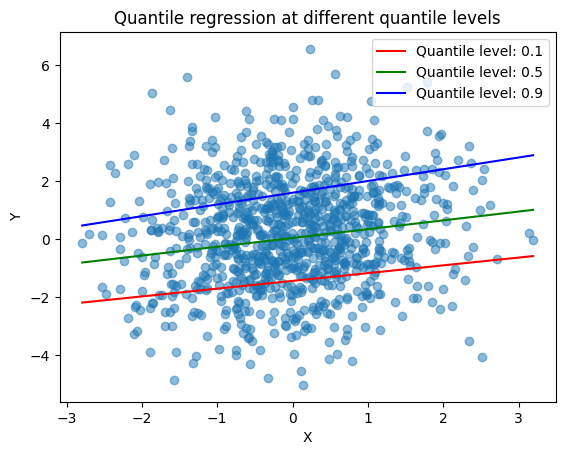

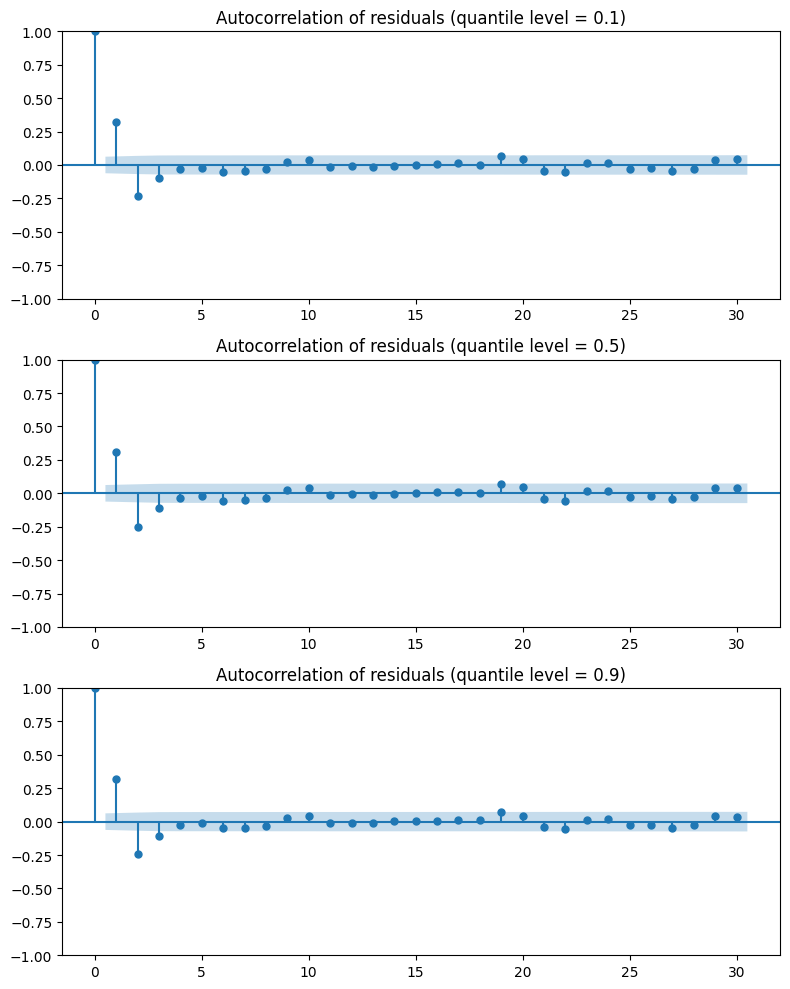

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3258
 Model:                       QuantReg   Bandwidth:                      0.5117
 Method:                 Least Squares   Sparsity:                        6.751
 Date:                Wed, 03 May 2023   No. Observations:                 1000
 Time:                        10:58:32   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.4417      0.065    -22.294      0.000      -1.569      -1.315
 x1             0.7153      0.037     19.459      0.000       0.643       0.787
 x2             0.2682      0.067      4.025      0.000       0.137   

In [194]:
fit_quantile(df)

In [251]:
''' 2.A OLS Liklihood            B method  results close to beta above'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

# Run optimization to find MLE
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

print('Estimated alpha:', result.x[0]) # Print estimated parameters
print('Estimated beta:', result.x[1])
print('Estimated gamma:', result.x[2])
print('Estimated theta:', result.x[3])
print('Estimated sigma:', result.x[4])


Estimated alpha: 0.1573969681781001
Estimated beta: 0.7299546622812911
Estimated gamma: 0.25832204791279917
Estimated theta: 0.062414754006661105
Estimated sigma: 1.1914041225773158


In [280]:
''' 2.B GLS Liklihood  with β_ols values       (exact same results as β_gls above)
'''
def GLS_logliklihood(df):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(beta_hat, X, y, S):
        T  = len(y)
        resid = y - X @ beta_hat
        return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
    beta_guess = np.zeros(X.shape[1]) # initial guess for beta
    res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
    beta_gls = res.x # the estimated beta is in res.x

    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [281]:
GLS_logliklihood(df)

GLS parameter estimates:
alpha_gls = 0.2344
beta_gls = 0.5844
gamma_gls = 0.2803


In [292]:
''' 2.C GLS Liklihoood that takes OLS liklihood values'''
#def OLS_GLS_loglikelihood(d):


def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

print('Estimated alpha:', beta_hat[0]) # Print estimated parameters
print('Estimated beta:', beta_hat[1])
print('Estimated gamma:', beta_hat[2])
print('Estimated theta:', theta_hat)
print('Estimated sigma:', sigma_hat)

df = df.astype('float64') # convert data to float64 data type

T = len(y)

y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters
    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

print("GLS parameter estimates:")
print("alpha_gls = {:.4f}".format(beta_gls[0]))
print("beta_gls = {:.4f}".format(beta_gls[1]))
print("gamma_gls = {:.4f}".format(beta_gls[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0])) 
                                                            ''' ***************QUESTION************** '''


Estimated alpha: 0.1573969681781001
Estimated beta: 0.7299546622812911
Estimated gamma: 0.25832204791279917
Estimated theta: 0.062414754006661105
Estimated sigma: 1.1914041225773158
GLS parameter estimates:
alpha_gls = 0.2345
beta_gls = 0.5842
gamma_gls = 0.2803


In [293]:
''' 3.A logliklihood_asymmetric_Laplace with β_ols values    --> very similar to just OLS '''
def logliklihood_asymmetric_Laplace(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x)) 
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε = y - X @ beta_hat - θ * z
    ε = ε.reshape((-1, 1))
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(beta_hat, X, y, S):
        T  = len(y)
        resid = y - X @ beta_hat - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε**2)/a       
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [295]:
p = 0.1
logliklihood_asymmetric_Laplace(df, p)
p = 0.5
logliklihood_asymmetric_Laplace(df, p)
p = 0.9
logliklihood_asymmetric_Laplace(df, p)

Laplace parameter estimates:
alpha_l = 0.1563
beta_l = 0.7301
gamma_l = 0.2577
Laplace parameter estimates:
alpha_l = 0.1563
beta_l = 0.7301
gamma_l = 0.2577
Laplace parameter estimates:
alpha_l = 0.1563
beta_l = 0.7301
gamma_l = 0.2577


In [298]:
''' 3.B logliklihood_asymmetric_Laplace with OLS liklihood values '''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε = y - X @ beta_hat - θ * z
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε**2)/a       
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


Laplace parameter estimates:
alpha_l = 0.1574
beta_l = 0.7300
gamma_l = 0.2583


In [ ]:
Laplace parameter estimates:
alpha_l = 0.2345
beta_l = 0.5842
gamma_l = 0.2803

In [304]:
''' 3.C logliklihood_asymmetric_Laplace with β_gls values     '''
def estimation_liklihood_asymmetric_Laplace_GLS(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y   # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε_l = y - beta_gls @ X.T - θ * z # = X @ beta_gls
    ε_l = ε.reshape((-1, 1))
    
    acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=50, alpha=0.05)
    sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
    sigma2_array_l = np.full(T, sigma2_l)
    rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
    S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
    
    def neg_log_likelihood(beta_gls, X, y, S_l):
        T  = len(y)
        resid = y - X @ beta_gls - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε_l**2)/a
        
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    res = optimize.minimize(neg_log_likelihood, beta_gls, args=(X, y, S_l)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [305]:
p = 0.1
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.5
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.9
estimation_liklihood_asymmetric_Laplace_GLS(df, p)

(1000,)
Laplace parameter estimates:
alpha_l = 0.2344
beta_l = 0.5844
gamma_l = 0.2803
(1000,)
Laplace parameter estimates:
alpha_l = 0.2344
beta_l = 0.5844
gamma_l = 0.2803
(1000,)
Laplace parameter estimates:
alpha_l = 0.2344
beta_l = 0.5844
gamma_l = 0.2803


In [299]:
''' 3.D logliklihood_asymmetric_Laplace with with GLS liklihood values'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] #OLS
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S): #GLS
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε_l = y - X @ beta_gls - θ * z
ε_l = ε.reshape((-1, 1))
    
acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=10, alpha=0.05)
sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
sigma2_array_l = np.full(T, sigma2_l)
rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
def neg_log_likelihood(beta_gls, X, y, S_l):
    T  = len(y)
    resid = y - X @ beta_gls - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε_l**2)/a
        
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_gls, args=(X, y, S_l)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


Laplace parameter estimates:
alpha_l = 0.2345
beta_l = 0.5842
gamma_l = 0.2803


In [ ]:
''' To do
check why laplace function gives same results
check other LAplace
bernd method optimization 
M = 1000 rep 
theta liklihoood
make beta dependent on quantile 
forecasts
 '''

In [ ]:
'''4.  Korobilis simulate data from asymmetric Laplace'''



In [ ]:
''' 5. Alternative Optimization'''